In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
import matplotlib
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
        sys.path.append(module_path)
        
from src import data_prepare

import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [2]:
post, thread=data_prepare.load_train_data()
post_test, thread_test=data_prepare.load_test_data()
label_map=data_prepare.load_label_map()

In [3]:
label_map

,type_id,description
type_name,,
bastard,0,These are mafia games where the moderator is a...
beginners-mafia,1,"Simple games with fixed rules, tailored toward..."
byor,2,"""Bring Your Own Role"": custom games where the ..."
classic,3,"In ""classic"" games, all players know what role..."
closed-setup,4,Closed setups mean that players do not know wh...
cybrid,5,"A custom, titled mafia game with multiple ""evi..."
kotm,6,"""King of the Mafia"": multiple mafia mini-games..."
non-mafia-game,7,Games which are sufficiently different from Ma...
other,8,"Non-game threads, such as discussion topics, s..."


In [3]:
num=len(thread)
train_data_to_clean=[]
test_data_to_clean=[]

In [5]:
post.head(3)

,thread_num,user,text,quotes
0,45016,Mephansteras,"Basically, this is where we talk about what ga...",
1,45016,dakarian,The currently running or about to run games (i...,
2,45016,webadict,And mine's started.\r\r\r\n\r\r\r\nI'll try to...,


In [6]:
thread.head(3)

,thread_num,thread_name,thread_label,thread_replies,thread_label_id
0,45016,Games Threshold Discussion and List [Vote for ...,other,5703,8
1,88720,New Player's Guide to the Subforum - New to Ma...,other,961,8
2,39338,Mafia: A Basic Tutorial,other,79,8


In [4]:
train_data_to_clean=data_prepare.get_all_text_data_from_posts(post, thread)
    
test_data_to_clean=data_prepare.get_all_text_data_from_posts(post_test, thread_test)

In [5]:
clean_train_data = [data_prepare.clean(s) for s in train_data_to_clean]
    
clean_test_data = [data_prepare.clean(s) for s in test_data_to_clean]

In [6]:
X_test=clean_test_data
X_train=clean_train_data
y_train=thread["thread_label_id"]
#X_train, X_val, y_train, y_val = train_test_split(clean_train_data, thread["thread_label_id"], test_size=0.2, random_state=213)

In [7]:
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2))

train_data_features = vectorizer.fit_transform(X_train).toarray()

test_data_features = vectorizer.transform(X_test).toarray()

In [15]:
def get_unique_users(post):
    return post.groupby(['thread_num','user'],sort=False).size().reset_index('user').rename(index=str, columns={0: "number_of_posts"})
def avg_and_dev_in_posts_number(df):
    return df.groupby("thread_num",sort=False).mean(), df.groupby("thread_num",sort=False).std()
def normalize(s):
    return (s-s.mean())/s.max()




def get_quotes_data(post):
    quotes_data=post[["thread_num","quotes"]]
    a=quotes_data.groupby("thread_num",sort=False).size()
    b=quotes_data[quotes_data["quotes"]!=''].groupby("thread_num",sort=False).size()
    numb_quotes=pd.Series(index=a.index)
    for index,item in a.items():
        if index in b.index:
            numb_quotes[index]=b.loc[index]
        else:
            numb_quotes[index]=0
    q_perc=(numb_quotes/a).as_matrix()
    numb_quotes=normalize(numb_quotes.astype(int).as_matrix())

    return numb_quotes, q_perc


In [16]:
unique_users = get_unique_users(post)
numb_unique=unique_users.groupby("thread_num",sort=False).nunique()["user"]
numb_unique= normalize(numb_unique)

avg_numb_of_posts, dev_numb_of_posts = avg_and_dev_in_posts_number(unique_users[["number_of_posts"]])
numb_quotes, q_perc=get_quotes_data(post)

In [17]:
unique_users_test = get_unique_users(post_test)
numb_unique_test=unique_users_test.groupby("thread_num",sort=False).nunique()["user"]
numb_unique_test=normalize(numb_unique_test)

avg_numb_of_posts_test, dev_numb_of_posts_test = avg_and_dev_in_posts_number(unique_users_test[["number_of_posts"]])
numb_quotes_test, q_perc_test=get_quotes_data(post_test)

In [19]:
number_train_posts=thread["thread_replies"].as_matrix()
number_train_posts=normalize(number_train_posts)

number_test_posts=thread_test["thread_replies"].as_matrix()
number_test_posts=normalize(number_test_posts)


train_data_features=np.append(np.append(np.append(number_train_posts.reshape(-1,1), numb_unique.as_matrix().reshape(-1,1),axis=1),
                              np.append(numb_quotes.reshape(-1,1),q_perc.reshape(-1,1), axis=1),axis=1),
                              np.append(avg_numb_of_posts.as_matrix().reshape(-1,1),train_data_features,axis=1),axis=1)
test_data_features=np.append(np.append(np.append(number_test_posts.reshape(-1,1),numb_unique_test.as_matrix().reshape(-1,1),axis=1),
                             np.append(numb_quotes_test.reshape(-1,1),q_perc_test.reshape(-1,1), axis=1),axis=1),
                             np.append(avg_numb_of_posts_test.as_matrix().reshape(-1,1),test_data_features,axis=1),axis=1)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=120),
    #ClassifierChain(LogisticRegression()),
    #BinaryRelevance(GaussianNB()),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression()
]
#add either pileline(saw it somewhere below) or creating of a datraframe to add additional features

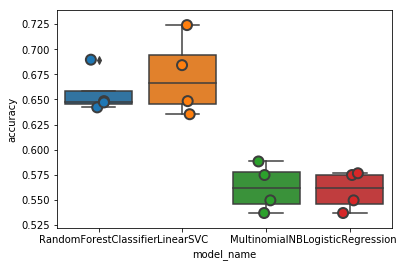

In [9]:
CV=4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_data_features, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.716728
LogisticRegression        0.621132
MultinomialNB             0.562310
RandomForestClassifier    0.674379
Name: accuracy, dtype: float64

In [ ]:
#classifiers move to separate file

classifier = ClassifierChain(LogisticRegression())

classifier.fit(train_data_features, y_train.as_matrix())

predictions = classifier.predict(val_data_features)
# accuracy
print("Accuracy = ",accuracy_score(y_val,predictions.A))
print("\n")

In [39]:
forest = RandomForestClassifier(n_estimators = 120)

forest = forest.fit(train_data_features, y_train)

test_predict = forest.predict(val_data_features)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val, val_predict)

print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

model_name
LinearSVC                 0.693936
LogisticRegression        0.614928
MultinomialNB             0.567072
RandomForestClassifier    0.659795
Name: accuracy, dtype: float64

In [13]:

classifier = BinaryRelevance(GaussianNB())

classifier.fit(train_data_features, y_train.as_matrix())

predictions = classifier.predict(val_data_features)

print("Accuracy = ",accuracy_score(y_val,predictions.A))

In [20]:
model = LinearSVC()
model.fit(train_data_features, y_train)
y_pred = model.predict(test_data_features)

#print(accuracy_score(y_pred, y_val))

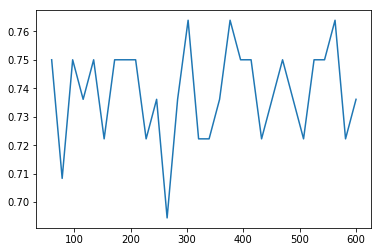

In [35]:
# not to forget, plot of accuracy from number of estimators
plt.plot(l,k)

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [14]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier(random_state=1000)
cls.fit(train_data_features, y_train)
third = cls.predict(test_data_features)

In [24]:
lab=pd.Series(pred)
ans = pd.concat([thread_test["thread_num"],lab], axis=1, keys=['thread_num', 'thread_label_id'])
ans=ans.set_index("thread_num")
ans.head()

,thread_label_id
thread_num,
126856,8
132415,8
134482,8
133728,1
134270,8


In [25]:
path=os.path.join(module_path,"submissions")
ans.to_csv(os.path.join(path,"sol26.csv"))